In [25]:
import os
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd

In [26]:
from keras.layers import Input, Lambda, Dense, Flatten,GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential

In [27]:
df = pd.read_csv('dataset/train.csv')
df

,Image,Class
0,image3476.jpg,Miscellaneous
1,image5198.jpg,Candle
2,image4183.jpg,Snowman
3,image1806.jpg,Miscellaneous
4,image7831.jpg,Miscellaneous
...,...,...
6464,image2096.jpg,Christmas_Tree
6465,image1474.jpg,Miscellaneous
6466,image4124.jpg,Airplane
6467,image7695.jpg,Candle


In [28]:
df['Class'].value_counts()

Miscellaneous     2801
Christmas_Tree    1539
Jacket             640
Candle             593
Airplane           535
Snowman            361
Name: Class, dtype: int64

<AxesSubplot:>

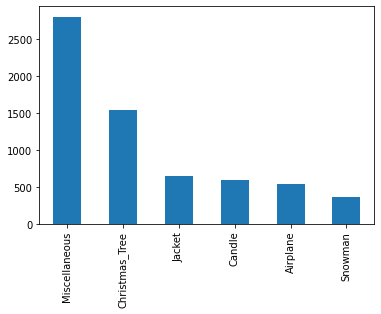

In [29]:
df['Class'].value_counts().plot.bar()

In [30]:
train_images = "dataset/train"
test_images = "dataset/test"

In [31]:
image_size = [299, 299]

In [32]:
df['Class'].values

array(['Miscellaneous', 'Candle', 'Snowman', ..., 'Airplane', 'Candle',
       'Airplane'], dtype=object)

In [33]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.2, stratify = df['Class'].values, shuffle=True)

In [34]:
train_df.shape

(5175, 2)

In [35]:
train_df.reset_index(inplace=True, drop=True)
valid_df.reset_index(inplace=True, drop=True)

In [36]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                  horizontal_flip=True)

In [37]:
training_set = train_datagen.flow_from_dataframe(dataframe=train_df, directory=train_images,
                                                x_col='Image', y_col='Class', class_mode='categorical',
                                                target_size=(299,299), batch_size=32)

Found 5175 validated image filenames belonging to 6 classes.


In [38]:
validation_datagen = ImageDataGenerator(rescale = 1./255)

In [39]:
validation_set = validation_datagen.flow_from_dataframe(dataframe=valid_df, directory=train_images,
                                                       x_col='Image', y_col='Class', class_mode='categorical',
                                                       target_size=(299,299), batch_size=32)

Found 1294 validated image filenames belonging to 6 classes.


In [40]:
image_size + [3]

[299, 299, 3]

In [41]:
inception = InceptionResNetV2(input_shape=image_size + [3], weights='imagenet',include_top=False)

for layer in inception.layers:
    layer.trainable=False

In [42]:
model = Sequential([
    inception,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(6, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               786944    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)              

In [43]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [44]:
r = model.fit_generator(training_set,
                        validation_data=validation_set,
                        epochs=12,
                        steps_per_epoch=training_set.n//32,
                        validation_steps=validation_set.n//32
                       )


Epoch 1/12
161/161 [==============================] - 175s 1s/step - loss: 0.9285 - accuracy: 0.6875 - val_loss: 0.4399 - val_accuracy: 0.8680
Epoch 2/12
161/161 [==============================] - 168s 1s/step - loss: 0.5278 - accuracy: 0.8238 - val_loss: 0.3671 - val_accuracy: 0.8805
Epoch 3/12
161/161 [==============================] - 168s 1s/step - loss: 0.4788 - accuracy: 0.8390 - val_loss: 0.3096 - val_accuracy: 0.9000
Epoch 4/12
161/161 [==============================] - 168s 1s/step - loss: 0.3974 - accuracy: 0.8643 - val_loss: 0.2778 - val_accuracy: 0.9086
Epoch 5/12
161/161 [==============================] - 167s 1s/step - loss: 0.3873 - accuracy: 0.8645 - val_loss: 0.3021 - val_accuracy: 0.9016
Epoch 6/12
161/161 [==============================] - 167s 1s/step - loss: 0.3809 - accuracy: 0.8752 - val_loss: 0.2934 - val_accuracy: 0.9039
Epoch 7/12
161/161 [==============================] - 168s 1s/step - loss: 0.3618 - accuracy: 0.8808 - val_loss: 0.3049 - val_accuracy: 0.8984

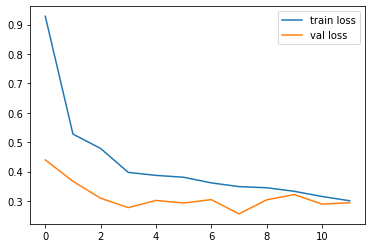

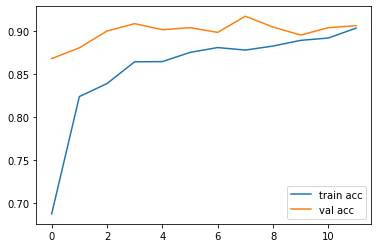

<Figure size 432x288 with 0 Axes>

In [45]:
# Loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# Accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [46]:
name=[]
y_pred=[]

labels = (training_set.class_indices)
labels = dict((v,k) for k,v in labels.items())

for i in os.listdir('dataset/test/'):
    name.append(i)
    i='dataset/test/'+i
    img=image.load_img(i,target_size=(299,299,3))
    img=image.img_to_array(img)/255
    pred=model.predict(img.reshape(1,299,299,3))
    y_pred.append(labels[np.argmax(pred[0])])
    

data=pd.DataFrame((zip(name,y_pred)),columns=['Image','Class'])
data.head()

,Image,Class
0,image10.jpg,Miscellaneous
1,image100.jpg,Airplane
2,image1013.jpg,Jacket
3,image1014.jpg,Miscellaneous
4,image1018.jpg,Christmas_Tree


In [47]:
data

,Image,Class
0,image10.jpg,Miscellaneous
1,image100.jpg,Airplane
2,image1013.jpg,Jacket
3,image1014.jpg,Miscellaneous
4,image1018.jpg,Christmas_Tree
...,...,...
3484,image9953.jpg,Christmas_Tree
3485,image9956.jpg,Miscellaneous
3486,image9958.jpg,Christmas_Tree
3487,image9960.jpg,Candle


In [48]:
data.to_csv('my_submission2-incep.csv',index=False)